# Reservoir model - only output is trained - evolutionary optimization

- Implemented a recurrent reservoir model, see summary(model) below for details on the layers. 
- Performing classification on the Digits dataset and MNIST dataset
- Results measured in logg loss (sum) and accuracy. 


In [103]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn import datasets
import numpy as np
import os, sys, tarfile
import requests
import shutil
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from pytorch_model_summary import summary
import copy

### The Digits Dataset:

In [104]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]
        self.transforms = transforms
        self.target_names = digits.target_names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [105]:
# Initiliazing the data loaders for the digits dataset. 

train_data_digits = Digits(mode='train')
val_data_digits = Digits(mode='val')
test_data_digits = Digits(mode='test')

LABELS = train_data_digits.target_names

train_loader_digits = DataLoader(train_data_digits, batch_size=50, shuffle=True)
val_loader_digits = DataLoader(val_data_digits, batch_size=50, shuffle=False)
test_loader_digits = DataLoader(test_data_digits, batch_size=50, shuffle=False)

result_dir = 'results_baseline_wiebe/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

6


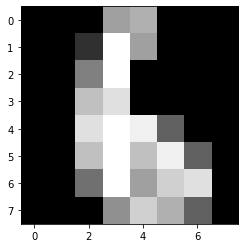

In [106]:
# Print an example digit and its according target label. - (digits dataset)

print(train_data_digits.targets[88])
plottable_image = np.reshape(train_data_digits.data[88], (8, 8))
plt.imshow(plottable_image, cmap='gray')

### The MNIST Dataset:

In [5]:
class MNIST(Dataset):
    """Complete MNIST dataset."""

    def __init__(self, mode='train', transforms=None):
        data_set_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

        data_set_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
        self.data = []
        self.targets = []
        
        if mode == 'train':
            for i in range(40000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        elif mode == 'val':
            for i in range(50000, 60000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        else:
            for i in range(len(data_set_test)):
                self.data.append(data_set_test[i][0].numpy())
                self.targets.append(data_set_test[i][1])
        
        self.targets = np.array(self.targets)
        self.data = np.array(self.data)
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [6]:
# Load in the MNIST dataset - (takes longer to load than Digits!, 6)
train_data_mnist = MNIST(mode='train')
val_data_mnist = MNIST(mode='val')
test_data_mnist = MNIST(mode='test')

train_loader_mnist = DataLoader(train_data_mnist, batch_size=50, shuffle=True)
val_loader_mnist = DataLoader(val_data_mnist, batch_size=50, shuffle=True)
test_loader_mnist = DataLoader(test_data_mnist, batch_size=50, shuffle=True)

1


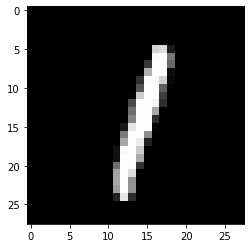

In [7]:
# Print an example MNIST digit and its according target label. - (digits dataset)

print(val_data_mnist.targets[1900])
plottable_image = np.reshape(val_data_mnist.data[1900], (28, 28))
plt.imshow(plottable_image, cmap='gray')

In [107]:
class Reservoir(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size, T, dataset = None):
        super(Reservoir, self).__init__()
        
        # Activation functions
        self.f_0 = nn.Tanh()
        self.f_t = nn.ReLU(inplace=False)
        self.f_y = nn.LogSoftmax(dim=1)
        
        # Amount of timesteps / recurrent layers
        self.T = T
        
        # Initialize the weights & layers
        self.initWeights(input_size, reservoir_size, output_size)
        self.initLayers(input_size, reservoir_size, output_size)
        
        # Boolean
        self.dataset = dataset

    def forward(self, input):
        
        used_input = input
        
        # Squeeze the used input in 2 dims if we use the MNIST dataset.
        if self.dataset == 'MNIST':
            three_d_tensor = used_input.squeeze(1)
            used_input = three_d_tensor.contiguous().view(three_d_tensor.size()[0], -1)  # 28 * 28 pixels = 784
        
        # Calculate c_0
        c = self.f_0(self.layer1(used_input))
        
        for t in range(self.T):
            # c_t =  f_t (W_r * c_t-1 + U * x_t)
            c = self.f_t(self.layer2(c) + self.layer3(used_input))
        
        # Calculate y = f_y ( W_out * c_t)
        y = self.f_y(self.layer4(c))
    
        return y
    
    def initWeights(self, input_size, reservoir_size, output_size):
        
        # Sample the initial weights from a uniform distribution - initialize the same as in the baseline model.
        self.W_in = nn.Parameter(data = torch.zeros(reservoir_size, input_size, requires_grad=False))
        self.W_in.data.uniform_(-0.01, 0.01)
        
        self.W_r = nn.Parameter(data = torch.zeros(reservoir_size, reservoir_size), requires_grad=False)
        self.W_r.data.uniform_(-0.01, 0.01)
        
        self.W_out = nn.Parameter(data = torch.zeros(output_size, reservoir_size), requires_grad=True)
        self.W_out.data.uniform_(-0.01, 0.01)
        
        self.U = nn.Parameter(data = torch.zeros(reservoir_size, input_size), requires_grad=False)
        self.U.data.uniform_(-0.01, 0.01)
        return
    
    def initLayers(self, input_size, reservoir_size, output_size):
        # Input layer
        self.layer1 = torch.nn.Linear(input_size, reservoir_size, bias=True)
        self.layer1.weight = self.W_in
        self.layer1.weight.requires_grad = False
        self.layer1.bias.requires_grad = False
        
        # Recurrent layer
        self.layer2 = torch.nn.Linear(reservoir_size, reservoir_size, bias=True)
        self.layer2.weight = self.W_r
        self.layer2.bias.requires_grad = False
        self.layer3 = torch.nn.Linear(input_size, reservoir_size, bias=True)
        self.layer3.weight = self.U
        self.layer3.bias.requires_grad = False
        
        # Output layer
        self.layer4 = torch.nn.Linear(reservoir_size, output_size, bias=True)
        self.layer4.weight = self.W_out
        self.layer4.bias.requires_grad = True
        return
        

In [108]:
# Function that transforms the tensor output to a predicted target name. 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i]

# Plot both accuracy as log loss. 
def plot_results(epochs, loss, accuracy):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Results Reservoir - Only output is trained.')
    ax1.set(ylabel='Loss')
    ax2.set(ylabel='Accuracy', xlabel='Epochs')
    
    ax1.plot(epochs, loss)
    ax2.plot(epochs, accuracy)
    

    plt.savefig('results_reservoir.png', bbox_inches='tight')
    #plt.close()


# Concatenating the results of all (64*)batches in the lists, calculating the total accuracy. 
def accuracy(pred_targets_list, gold_targets_list):
    total_correct = 0
    total_amount = 0
    
    zip_list = zip(pred_targets_list, gold_targets_list)
    for pred_targets, gold_targets in zip_list:
        total_correct += (pred_targets == gold_targets).float().sum()
        total_amount += len(pred_targets)
    
    accuracy = 100 * total_correct / total_amount

    return accuracy.item()

# Evaluation -> used for validation and test set. 
def evaluation(val_loader, model, epoch, loss_function):
    
    #Evaluating our performance so far
    model.eval()
    
    # Store all results in a list to calculate the accuracy. 
    pred_target_total_acc = []
    target_total_acc = []
    
    # Initialize counters / c
    loss = 0.
    N = 0.
    
    # Iterating over the validation set batches, acquiring tensor formatted results. 
    for indx_batch, (batch, targets) in enumerate(val_loader):
        output = model.forward(batch)
        pred_targets = np.array([])
        for item in output:
            pred_targets = np.append(pred_targets, categoryFromOutput(item))
        pred_targets = torch.from_numpy(pred_targets).int()
        
        # Calculating loss
        loss_t = loss_function(output, targets.long())
        loss = loss + loss_t.item()
        N = N + batch.shape[0]
        
        #Append the batch result to a list of all results
        pred_target_total_acc.append(pred_targets)
        target_total_acc.append(targets)
    
    # Store the loss corrected by its size
    loss = loss / N   
        
    total_accuracy = accuracy(pred_target_total_acc, target_total_acc)
    print('Epoch: %s - Loss of: %s - Accuracy of: %s' %(epoch, loss,total_accuracy))
    
    return epoch, loss, total_accuracy

In [109]:
def training(model, train_loader, val_loader, num_epochs, optimizer, loss_function, max_loss_iter):    
    
    print('Training started for %s epochs.'  %(num_epochs))
    epochs = []
    accuracy_results = []
    loss_results = []
    best_loss = 10000 # Picking random high number to assure correct functionality
    loss_iter = 0

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(num_epochs):

        # Training
        model.train()
        for indx_batch, (batch, targets) in enumerate(train_loader):

            output = model.forward(batch)

            targets = targets.long()

            loss = loss_function(output, targets)
            
            # Optional print of loss per batch
            #print('Loss in batch %s is: %s' %(indx_batch, loss))
        
            # Perform back prop after each batch
            loss = loss_function(output, targets)
            optimizer.zero_grad()
            loss.backward(retain_graph = True)
            optimizer.step()

        # Perform evaluation after each epoch
        epoch, loss_eval, accuracy_eval = evaluation(val_loader, model, epoch, loss_function)
        epochs.append(epoch)
        accuracy_results.append(accuracy_eval)
        loss_results.append(loss_eval)

        '''if epoch == 0:
            print('* Saving 1st epoch model *')
            torch.save(model, 'trained_reservoir.model')
            best_loss = loss_eval
        else:
            if loss_eval < best_loss:
                print('* Saving new best model *')
                torch.save(model, 'trained_reservoir.model')
                best_loss = loss_eval
                loss_iter = 0
            else:
                loss_iter += 1

            # If loss has not improved for an arbitrary amount of epochs: '''
        if loss_iter > max_loss_iter:
            break

    dict_results = {
        'model': model,
        'epoch': epochs,
        'loss_results': loss_results,
        'accuracy_results':accuracy_results,
        'best_loss': best_loss,
        'loss_iter': loss_iter,
    }
    
    #plot_results(epochs, loss_results, accuracy_results)
    
    return dict_results

    

In [117]:
input_size_digits = 64  # 8 * 8 pixels
input_size_mnist = 784  # 28 * 28 pixels
reservoir_size = 128
n_labels = 10
lr_SGD = 0.0001
momentum_SGD = 0.9
n_epochs = 3  # with backprop
max_loss_iter = 10
batch_size= 50
T = 5

population_size = 25
generations = 50

In [118]:
class EA(object):
    def __init__(self,  population_size, val_loader, loss_function, input_size, reservoir_size, n_labels):
        self.population_size = population_size
        self.val_loader = val_loader
        self.loss_function = loss_function
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = n_labels

    def fitness(self, population):
        
        # Evaluate performance of every model in the population, add the results to results list. 
        for reservoir in population:
            epoch, loss, total_accuracy = evaluation(self.val_loader, 
                                                     reservoir['model'], 
                                                     reservoir['epoch'][-1]+1, 
                                                     loss_function)
            reservoir['epoch'].append(epoch)
            reservoir['loss_results'].append(loss)
            reservoir['accuracy_results'].append(total_accuracy)
            
            # If we find a new best model, save it.
            # Still have to fine tune this , make a directory for all the models. 
            '''if loss < reservoir['best_loss']:
                print('* Saving new best model *')
                torch.save(reservoir['model'], 'trained_reservoir.model')
                reservoir['best_loss'] = loss
                reservoir['loss_iter'] = 0
            else:
                reservoir['loss_iter'] += 1'''

        return population

    def mutation(self, pop):
        
        # Using random perturbation:
        #pop, mut_pop = self.random_perturbation(pop)
        
        # Using differential mutation:
        perturb_rate = 1
        pop, mut_pop = self.diff_mutation(pop, perturb_rate)
        
        return pop, mut_pop 
    
    def diff_mutation(self, pop, perturb_rate):
        mut_pop = copy.deepcopy(pop)
        
        for reservoir in mut_pop:
            
            #Changed name to make more readable
            model = reservoir['model']
            
            # Randomly sample 2 models from the population & split them up
            sample = random.sample(pop, 2)
            sample1 = sample[0]['model']
            sample2 = sample[1]['model']
            
            # Perturb the weights
            model.W_in +=  perturb_rate * (sample1.W_in - sample2.W_in)
            model.W_r += perturb_rate * (sample1.W_r - sample2.W_r)
            model.U += perturb_rate * (sample1.U - sample2.U)
            temp_w_out = model.W_out + perturb_rate * (sample1.W_out - sample2.W_out)
            model.W_out = nn.Parameter(temp_w_out, requires_grad = False)
        
        return pop, mut_pop
    
    def random_perturbation(self, pop):
        mut_pop = copy.deepcopy(pop)
        
        # Using a uniform distribution to sample from
        W_in_sample = torch.empty(self.reservoir_size, self.input_size).uniform_(-0.005, 0.005)
        W_r_sample = torch.empty(self.reservoir_size, self.reservoir_size).uniform_(-0.005, 0.005)
        W_out_sample = torch.empty(self.output_size, self.reservoir_size).uniform_(-0.005, 0.005)
        U_sample = torch.empty(self.reservoir_size, self.input_size).uniform_(-0.005, 0.005)
        
        for reservoir in mut_pop:
            reservoir['model'].W_in += W_in_sample
            reservoir['model'].W_r += W_r_sample
            reservoir['model'].U += U_sample
            
            # We have to turn off requires grad,
            # because pytorch does not allow inplace mutations on tensors which are used for backprop.
            # See https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/2 .
            reservoir['model'].W_out.requires_grad = False
            
            reservoir['model'].W_out += W_out_sample
        
        return pop, mut_pop

    def recombination(self, pop):  # Idea: swapp the weight matrices among the population
        mut_pop = copy.deepcopy(pop)
        
        # Last model is not changed
        for reservoir in mut_pop:
            pass
        
        return mut_pop 

    def selection(self, pop, mut_pop):
        
        # Draft version, we now just pick the ones with the smallest loss. 
        total_pop = pop + mut_pop
        
        total_pop = sorted(total_pop, key=lambda k: k['loss_results'][-1]) 
        
        new_pop = total_pop[:len(pop)]
        
        return new_pop
    
    def step(self, pop):
        pop, mut_pop = self.mutation(pop)
        
        print('No mutation - nothing') # adding the validation results to the pop dict object
        pop = self.fitness(pop)
        print('Mutation') # adding the validation results to the pop dict object
        mut_pop = self.fitness(mut_pop)
        
        #self.recombination(childs)
        
        new_pop = self.selection(pop, mut_pop)
        
        return new_pop


In [119]:
# Initialize population - train by backprop for a few epochs. 
model_set_digits = []

for i in range(population_size):
    model_digits = Reservoir(input_size_digits, reservoir_size, n_labels, T, dataset = 'Digits')
    optimizer_digits = optim.SGD([p for p in model_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
    loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.
    trained_model_digits = training(model_digits, train_loader_digits, val_loader_digits, n_epochs, optimizer_digits, loss_function, max_loss_iter)
    model_set_digits.append(trained_model_digits)


Training started for 3 epochs.
Epoch: 0 - Loss of: 2.252822047642299 - Accuracy of: 33.14285659790039
Epoch: 1 - Loss of: 2.1774798801967075 - Accuracy of: 62.28571319580078
Epoch: 2 - Loss of: 2.1028721836635045 - Accuracy of: 79.71428680419922
Training started for 3 epochs.
Epoch: 0 - Loss of: 2.2590239388602122 - Accuracy of: 18.285715103149414
Epoch: 1 - Loss of: 2.191129106794085 - Accuracy of: 66.0
Epoch: 2 - Loss of: 2.123853280203683 - Accuracy of: 74.28571319580078
Training started for 3 epochs.
Epoch: 0 - Loss of: 2.2597933523995537 - Accuracy of: 49.42856979370117
Epoch: 1 - Loss of: 2.1949193028041294 - Accuracy of: 69.42857360839844
Epoch: 2 - Loss of: 2.130273742675781 - Accuracy of: 70.85713958740234
Training started for 3 epochs.
Epoch: 0 - Loss of: 2.2445875113351006 - Accuracy of: 43.71428680419922
Epoch: 1 - Loss of: 2.1569187709263393 - Accuracy of: 57.42856979370117
Epoch: 2 - Loss of: 2.0699198041643414 - Accuracy of: 64.57142639160156
Training started for 3 epoch

In [120]:
# Performing one evolution step, 3rd epoch, only mutation, no selection or recombination yet
ea = EA(population_size, val_loader_digits, loss_function, input_size_digits, reservoir_size, n_labels)
    
new_pop = model_set_digits

for i in range(generations):
    new_pop = ea.step(new_pop)
    
best_pop = sorted(new_pop, key=lambda k: k['loss_results'][-1] , reverse=False) 
        
best_unit = best_pop[0]

No mutation - nothing
Epoch: 3 - Loss of: 2.1028721836635045 - Accuracy of: 79.71428680419922
Epoch: 3 - Loss of: 2.123853280203683 - Accuracy of: 74.28571319580078
Epoch: 3 - Loss of: 2.130273742675781 - Accuracy of: 70.85713958740234
Epoch: 3 - Loss of: 2.0699198041643414 - Accuracy of: 64.57142639160156
Epoch: 3 - Loss of: 2.1005174691336497 - Accuracy of: 71.14286041259766
Epoch: 3 - Loss of: 2.0589039393833706 - Accuracy of: 80.28571319580078
Epoch: 3 - Loss of: 2.1569978332519533 - Accuracy of: 76.0
Epoch: 3 - Loss of: 2.103641335623605 - Accuracy of: 73.42857360839844
Epoch: 3 - Loss of: 2.1017168971470426 - Accuracy of: 80.0
Epoch: 3 - Loss of: 2.131104060581752 - Accuracy of: 75.14286041259766
Epoch: 3 - Loss of: 2.0725818743024553 - Accuracy of: 78.28571319580078
Epoch: 3 - Loss of: 2.118915557861328 - Accuracy of: 66.57142639160156
Epoch: 3 - Loss of: 2.1183297293526784 - Accuracy of: 82.28571319580078
Epoch: 3 - Loss of: 2.1293412126813616 - Accuracy of: 79.71428680419922
E

Epoch: 5 - Loss of: 2.103641335623605 - Accuracy of: 73.42857360839844
Epoch: 5 - Loss of: 2.1043108040945873 - Accuracy of: 84.28571319580078
Epoch: 5 - Loss of: 2.1096664210728235 - Accuracy of: 83.14286041259766
Epoch: 5 - Loss of: 2.1128927830287387 - Accuracy of: 70.85713958740234
Epoch: 5 - Loss of: 2.115538046700614 - Accuracy of: 46.57143020629883
Epoch: 5 - Loss of: 2.1161225019182477 - Accuracy of: 41.14285659790039
Epoch: 5 - Loss of: 2.116447187151228 - Accuracy of: 38.85714340209961
Epoch: 5 - Loss of: 2.1183297293526784 - Accuracy of: 82.28571319580078
Mutation
Epoch: 5 - Loss of: 1.8955603245326451 - Accuracy of: 57.14285659790039
Epoch: 5 - Loss of: 1.9452171543666295 - Accuracy of: 63.71428680419922
Epoch: 5 - Loss of: 1.9562061636788504 - Accuracy of: 58.28571319580078
Epoch: 5 - Loss of: 2.054402160644531 - Accuracy of: 33.42856979370117
Epoch: 5 - Loss of: 2.076209716796875 - Accuracy of: 25.428571701049805
Epoch: 5 - Loss of: 2.1432286507742746 - Accuracy of: 26.0


Epoch: 7 - Loss of: 1.717043718610491 - Accuracy of: 60.85714340209961
Epoch: 7 - Loss of: 2.9164776175362723 - Accuracy of: 0.0
Epoch: 7 - Loss of: 1.4809080941336497 - Accuracy of: 80.28571319580078
Epoch: 7 - Loss of: 2.181043003627232 - Accuracy of: 16.85714340209961
Epoch: 7 - Loss of: 2.3270892333984374 - Accuracy of: 24.285715103149414
Epoch: 7 - Loss of: 2.1831573486328124 - Accuracy of: 29.428571701049805
Epoch: 7 - Loss of: 2.17124516078404 - Accuracy of: 14.0
Epoch: 7 - Loss of: 2.3246043831961494 - Accuracy of: 8.857142448425293
Epoch: 7 - Loss of: 1.8781142534528459 - Accuracy of: 40.0
Epoch: 7 - Loss of: 1.853584703717913 - Accuracy of: 52.28571319580078
Epoch: 7 - Loss of: 2.1068315778459823 - Accuracy of: 54.57143020629883
Epoch: 7 - Loss of: 2.027758047921317 - Accuracy of: 31.14285659790039
Epoch: 7 - Loss of: 1.9594964381626674 - Accuracy of: 31.14285659790039
Epoch: 7 - Loss of: 2.180232216971261 - Accuracy of: 18.0
Epoch: 7 - Loss of: 2.47918947492327 - Accuracy of

Epoch: 10 - Loss of: 1.4495346069335937 - Accuracy of: 46.57143020629883
Epoch: 10 - Loss of: 1.4508750479561943 - Accuracy of: 49.42856979370117
Epoch: 10 - Loss of: 1.4809080941336497 - Accuracy of: 80.28571319580078
Epoch: 10 - Loss of: 1.5000244140625 - Accuracy of: 63.42856979370117
Epoch: 10 - Loss of: 1.503351331438337 - Accuracy of: 55.71428680419922
Epoch: 10 - Loss of: 1.533644300188337 - Accuracy of: 65.42857360839844
Epoch: 10 - Loss of: 1.543990478515625 - Accuracy of: 46.0
Epoch: 10 - Loss of: 1.5542668151855468 - Accuracy of: 55.71428680419922
Epoch: 10 - Loss of: 1.5823755972726004 - Accuracy of: 52.57143020629883
Epoch: 10 - Loss of: 1.582899409702846 - Accuracy of: 43.42856979370117
Epoch: 10 - Loss of: 1.6701403590611048 - Accuracy of: 61.71428680419922
Epoch: 10 - Loss of: 1.699468710763114 - Accuracy of: 48.28571319580078
Epoch: 10 - Loss of: 1.717043718610491 - Accuracy of: 60.85714340209961
Epoch: 10 - Loss of: 1.7367694527762276 - Accuracy of: 53.14285659790039


Epoch: 12 - Loss of: 1.513249969482422 - Accuracy of: 47.71428680419922
Epoch: 12 - Loss of: 1.533644300188337 - Accuracy of: 65.42857360839844
Epoch: 12 - Loss of: 1.543990478515625 - Accuracy of: 46.0
Epoch: 12 - Loss of: 1.5542668151855468 - Accuracy of: 55.71428680419922
Epoch: 12 - Loss of: 1.5823755972726004 - Accuracy of: 52.57143020629883
Epoch: 12 - Loss of: 1.582899409702846 - Accuracy of: 43.42856979370117
Epoch: 12 - Loss of: 1.5843631853376117 - Accuracy of: 53.71428680419922
Epoch: 12 - Loss of: 1.6701403590611048 - Accuracy of: 61.71428680419922
Epoch: 12 - Loss of: 1.6812481907435826 - Accuracy of: 46.0
Mutation
Epoch: 12 - Loss of: 1.433824484688895 - Accuracy of: 48.85714340209961
Epoch: 12 - Loss of: 1.8583888462611606 - Accuracy of: 41.14285659790039
Epoch: 12 - Loss of: 6.670848999023438 - Accuracy of: 31.14285659790039
Epoch: 12 - Loss of: 1.545387682233538 - Accuracy of: 42.85714340209961
Epoch: 12 - Loss of: 1.1786997440883091 - Accuracy of: 60.0
Epoch: 12 - Los

Epoch: 14 - Loss of: 1.576907719203404 - Accuracy of: 50.85714340209961
Epoch: 14 - Loss of: 5.314859575544085 - Accuracy of: 24.285715103149414
Epoch: 14 - Loss of: 1.4423692539760045 - Accuracy of: 57.14285659790039
Epoch: 14 - Loss of: 1.5940775844029018 - Accuracy of: 48.0
Epoch: 14 - Loss of: 1.7113900756835938 - Accuracy of: 58.0
Epoch: 14 - Loss of: 1.6828168160574777 - Accuracy of: 50.85714340209961
Epoch: 14 - Loss of: 3.901182686941964 - Accuracy of: 36.85714340209961
Epoch: 14 - Loss of: 3.403376159667969 - Accuracy of: 28.85714340209961
Epoch: 14 - Loss of: 3.473099670410156 - Accuracy of: 12.857142448425293
Epoch: 14 - Loss of: 2.997433362688337 - Accuracy of: 33.42856979370117
Epoch: 14 - Loss of: 2.172047119140625 - Accuracy of: 24.285715103149414
Epoch: 14 - Loss of: 8.638901977539062 - Accuracy of: 20.285715103149414
Epoch: 14 - Loss of: 2.6864122227260046 - Accuracy of: 34.85714340209961
Epoch: 14 - Loss of: 1.5937280055454799 - Accuracy of: 43.42856979370117
Epoch: 1

Epoch: 16 - Loss of: 1.543660866873605 - Accuracy of: 55.71428680419922
Epoch: 16 - Loss of: 2.8080202811104913 - Accuracy of: 29.714284896850586
Epoch: 16 - Loss of: 1.5609628513881137 - Accuracy of: 46.85714340209961
Epoch: 16 - Loss of: 1.886539306640625 - Accuracy of: 43.71428680419922
No mutation - nothing
Epoch: 17 - Loss of: 1.1706446620396205 - Accuracy of: 60.85714340209961
Epoch: 17 - Loss of: 1.1786997440883091 - Accuracy of: 60.0
Epoch: 17 - Loss of: 1.2320991952078684 - Accuracy of: 59.14285659790039
Epoch: 17 - Loss of: 1.234369604928153 - Accuracy of: 57.14285659790039
Epoch: 17 - Loss of: 1.248682174682617 - Accuracy of: 60.57143020629883
Epoch: 17 - Loss of: 1.2488196563720704 - Accuracy of: 59.14285659790039
Epoch: 17 - Loss of: 1.2494273267473492 - Accuracy of: 53.42856979370117
Epoch: 17 - Loss of: 1.2867690822056361 - Accuracy of: 67.42857360839844
Epoch: 17 - Loss of: 1.2871016911097934 - Accuracy of: 56.57143020629883
Epoch: 17 - Loss of: 1.2939678519112723 - Acc

Epoch: 19 - Loss of: 1.2843613542829242 - Accuracy of: 54.85714340209961
Epoch: 19 - Loss of: 1.2867690822056361 - Accuracy of: 67.42857360839844
Epoch: 19 - Loss of: 1.2871016911097934 - Accuracy of: 56.57143020629883
Epoch: 19 - Loss of: 1.2939678519112723 - Accuracy of: 58.85714340209961
Epoch: 19 - Loss of: 1.2939679282052177 - Accuracy of: 58.85714340209961
Epoch: 19 - Loss of: 1.2973735046386718 - Accuracy of: 58.85714340209961
Epoch: 19 - Loss of: 1.3081211744035994 - Accuracy of: 54.57143020629883
Epoch: 19 - Loss of: 1.3122346823556084 - Accuracy of: 58.57143020629883
Epoch: 19 - Loss of: 1.3122347477504186 - Accuracy of: 58.57143020629883
Epoch: 19 - Loss of: 1.3150396946498326 - Accuracy of: 64.0
Epoch: 19 - Loss of: 1.3163641793387277 - Accuracy of: 49.42856979370117
Epoch: 19 - Loss of: 1.3255462646484375 - Accuracy of: 54.28571319580078
Epoch: 19 - Loss of: 1.3310529000418527 - Accuracy of: 60.28571319580078
Epoch: 19 - Loss of: 1.3818798065185547 - Accuracy of: 50.857143

Epoch: 21 - Loss of: 1.914632350376674 - Accuracy of: 44.85714340209961
Epoch: 21 - Loss of: 1.479478519984654 - Accuracy of: 50.57143020629883
Epoch: 21 - Loss of: 1.2636119842529296 - Accuracy of: 59.42856979370117
Epoch: 21 - Loss of: 1.5421125902448383 - Accuracy of: 47.42856979370117
Epoch: 21 - Loss of: 3.293862653459821 - Accuracy of: 27.714284896850586
Epoch: 21 - Loss of: 2.018102722167969 - Accuracy of: 24.85714340209961
Epoch: 21 - Loss of: 1.9741006905691965 - Accuracy of: 41.71428680419922
Epoch: 21 - Loss of: 4.457567836216517 - Accuracy of: 24.0
Epoch: 21 - Loss of: 4.282418300083705 - Accuracy of: 6.285714149475098
Epoch: 21 - Loss of: 1.2872093309674943 - Accuracy of: 50.85714340209961
Epoch: 21 - Loss of: 1.6156902422223773 - Accuracy of: 46.28571319580078
Epoch: 21 - Loss of: 1.7913970947265625 - Accuracy of: 32.57143020629883
Epoch: 21 - Loss of: 1.7229485212053572 - Accuracy of: 40.57143020629883
Epoch: 21 - Loss of: 10.991727992466517 - Accuracy of: 15.42857170104

Epoch: 23 - Loss of: 1.1566273498535156 - Accuracy of: 61.71428680419922
Epoch: 23 - Loss of: 1.3390306309291296 - Accuracy of: 55.71428680419922
Epoch: 23 - Loss of: 1.3214141409737723 - Accuracy of: 52.28571319580078
Epoch: 23 - Loss of: 1.2427083260672434 - Accuracy of: 52.85714340209961
Epoch: 23 - Loss of: 1.8652537972586496 - Accuracy of: 41.14285659790039
Epoch: 23 - Loss of: 1.7766556440080916 - Accuracy of: 38.28571319580078
Epoch: 23 - Loss of: 1.2088411930629186 - Accuracy of: 62.57143020629883
Epoch: 23 - Loss of: 2.246286381312779 - Accuracy of: 32.57143020629883
Epoch: 23 - Loss of: 1.8666202436174666 - Accuracy of: 30.571428298950195
Epoch: 23 - Loss of: 1.7410045732770647 - Accuracy of: 37.71428680419922
Epoch: 23 - Loss of: 6.532089494977678 - Accuracy of: 7.714285850524902
No mutation - nothing
Epoch: 24 - Loss of: 1.1566272953578405 - Accuracy of: 61.71428680419922
Epoch: 24 - Loss of: 1.1566273498535156 - Accuracy of: 61.71428680419922
Epoch: 24 - Loss of: 1.1629142

Epoch: 26 - Loss of: 1.1581055123465402 - Accuracy of: 66.0
Epoch: 26 - Loss of: 1.162914297921317 - Accuracy of: 63.71428680419922
Epoch: 26 - Loss of: 1.1706446620396205 - Accuracy of: 60.85714340209961
Epoch: 26 - Loss of: 1.1706446729387556 - Accuracy of: 60.85714340209961
Epoch: 26 - Loss of: 1.1706446838378906 - Accuracy of: 60.85714340209961
Epoch: 26 - Loss of: 1.1786997440883091 - Accuracy of: 60.0
Epoch: 26 - Loss of: 1.1992076437813894 - Accuracy of: 61.14285659790039
Epoch: 26 - Loss of: 1.2088411930629186 - Accuracy of: 62.57143020629883
Epoch: 26 - Loss of: 1.2320991952078684 - Accuracy of: 59.14285659790039
Epoch: 26 - Loss of: 1.2337049647739955 - Accuracy of: 62.0
Epoch: 26 - Loss of: 1.234369604928153 - Accuracy of: 57.14285659790039
Epoch: 26 - Loss of: 1.2343696158272879 - Accuracy of: 57.14285659790039
Epoch: 26 - Loss of: 1.237535117013114 - Accuracy of: 63.71428680419922
Epoch: 26 - Loss of: 1.2427083151681082 - Accuracy of: 52.85714340209961
Epoch: 26 - Loss of:

Epoch: 28 - Loss of: 1.2375350952148438 - Accuracy of: 63.71428680419922
Epoch: 28 - Loss of: 1.237535117013114 - Accuracy of: 63.71428680419922
Epoch: 28 - Loss of: 1.2427083151681082 - Accuracy of: 52.85714340209961
Epoch: 28 - Loss of: 1.2427083151681082 - Accuracy of: 52.85714340209961
Epoch: 28 - Loss of: 1.2427083260672434 - Accuracy of: 52.85714340209961
Epoch: 28 - Loss of: 1.2427083478655134 - Accuracy of: 52.85714340209961
Epoch: 28 - Loss of: 1.2427083587646484 - Accuracy of: 52.85714340209961
Mutation
Epoch: 28 - Loss of: 2.0182989283970425 - Accuracy of: 30.571428298950195
Epoch: 28 - Loss of: 1.234369637625558 - Accuracy of: 57.14285659790039
Epoch: 28 - Loss of: 2.3445494515555247 - Accuracy of: 45.71428680419922
Epoch: 28 - Loss of: 6.157422005789621 - Accuracy of: 25.714284896850586
Epoch: 28 - Loss of: 1.2222886875697545 - Accuracy of: 60.57143020629883
Epoch: 28 - Loss of: 1.1706447056361606 - Accuracy of: 60.85714340209961
Epoch: 28 - Loss of: 1.6905838448660715 - A

Epoch: 30 - Loss of: 1.2269173867361887 - Accuracy of: 55.71428680419922
Epoch: 30 - Loss of: 1.7265072413853237 - Accuracy of: 33.14285659790039
Epoch: 30 - Loss of: 2.5679021780831475 - Accuracy of: 14.0
Epoch: 30 - Loss of: 1.7634650530133928 - Accuracy of: 43.71428680419922
Epoch: 30 - Loss of: 1.2337050519670758 - Accuracy of: 62.0
Epoch: 30 - Loss of: 6.826135951450893 - Accuracy of: 13.142857551574707
Epoch: 30 - Loss of: 1.2533234405517577 - Accuracy of: 55.71428680419922
Epoch: 30 - Loss of: 1.346348876953125 - Accuracy of: 60.57143020629883
Epoch: 30 - Loss of: 1.2088411276681084 - Accuracy of: 62.57143020629883
Epoch: 30 - Loss of: 1.1992076764787947 - Accuracy of: 61.14285659790039
Epoch: 30 - Loss of: 2.0017735944475445 - Accuracy of: 30.85714340209961
Epoch: 30 - Loss of: 1.5720062473842076 - Accuracy of: 46.28571319580078
Epoch: 30 - Loss of: 1.7983311898367746 - Accuracy of: 31.714284896850586
Epoch: 30 - Loss of: 1.2088411603655134 - Accuracy of: 62.57143020629883
Epoc

Epoch: 32 - Loss of: 1.2088411385672433 - Accuracy of: 62.57143020629883
Epoch: 32 - Loss of: 1.1922110748291015 - Accuracy of: 59.71428680419922
Epoch: 32 - Loss of: 17.461759905133928 - Accuracy of: 16.85714340209961
No mutation - nothing
Epoch: 33 - Loss of: 0.9809216853550502 - Accuracy of: 66.57142639160156
Epoch: 33 - Loss of: 1.152880575997489 - Accuracy of: 63.71428680419922
Epoch: 33 - Loss of: 1.1566272953578405 - Accuracy of: 61.71428680419922
Epoch: 33 - Loss of: 1.1566273062569754 - Accuracy of: 61.71428680419922
Epoch: 33 - Loss of: 1.1566273280552455 - Accuracy of: 61.71428680419922
Epoch: 33 - Loss of: 1.1566273498535156 - Accuracy of: 61.71428680419922
Epoch: 33 - Loss of: 1.1566273498535156 - Accuracy of: 61.71428680419922
Epoch: 33 - Loss of: 1.1581055123465402 - Accuracy of: 66.0
Epoch: 33 - Loss of: 1.162914297921317 - Accuracy of: 63.71428680419922
Epoch: 33 - Loss of: 1.1706446620396205 - Accuracy of: 60.85714340209961
Epoch: 33 - Loss of: 1.1706446729387556 - Ac

Epoch: 35 - Loss of: 1.1706446620396205 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706446620396205 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706446729387556 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706446838378906 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706447056361606 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706447056361606 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706447056361606 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706447165352958 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706447274344307 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1706447383335659 - Accuracy of: 60.85714340209961
Epoch: 35 - Loss of: 1.1786997331891742 - Accuracy of: 60.0
Epoch: 35 - Loss of: 1.1786997440883091 - Accuracy of: 60.0
Epoch: 35 - Loss of: 1.1786997767857144 - Accuracy of: 60.0
Epoch: 35 - Loss of: 1.1786997767857144 - Accuracy of: 60.0
Mutation
Epoch: 35 - Loss of: 

Epoch: 37 - Loss of: 3.111184779575893 - Accuracy of: 3.4285714626312256
Epoch: 37 - Loss of: 1.3577304404122488 - Accuracy of: 51.42856979370117
Epoch: 37 - Loss of: 2.724764142717634 - Accuracy of: 10.285714149475098
Epoch: 37 - Loss of: 2.0012619890485492 - Accuracy of: 47.42856979370117
Epoch: 37 - Loss of: 1.1566273389543806 - Accuracy of: 61.71428680419922
Epoch: 37 - Loss of: 2.3445496259416854 - Accuracy of: 45.71428680419922
Epoch: 37 - Loss of: 1.1706447165352958 - Accuracy of: 60.85714340209961
Epoch: 37 - Loss of: 61.469314313616074 - Accuracy of: 11.714285850524902
Epoch: 37 - Loss of: 1.1566273171561106 - Accuracy of: 61.71428680419922
Epoch: 37 - Loss of: 1.3724978964669363 - Accuracy of: 52.57143020629883
Epoch: 37 - Loss of: 1.1566273498535156 - Accuracy of: 61.71428680419922
Epoch: 37 - Loss of: 1.1566273498535156 - Accuracy of: 61.71428680419922
Epoch: 37 - Loss of: 1.7586293683733258 - Accuracy of: 41.42856979370117
Epoch: 37 - Loss of: 2.724764142717634 - Accuracy 

Epoch: 39 - Loss of: 1.6973502894810268 - Accuracy of: 54.85714340209961
Epoch: 39 - Loss of: 1.3577303859165737 - Accuracy of: 51.42856979370117
Epoch: 39 - Loss of: 1.1566273716517856 - Accuracy of: 61.71428680419922
Epoch: 39 - Loss of: 1.1566273280552455 - Accuracy of: 61.71428680419922
Epoch: 39 - Loss of: 1.319405986240932 - Accuracy of: 55.71428680419922
Epoch: 39 - Loss of: 1.1566273825509208 - Accuracy of: 61.71428680419922
Epoch: 39 - Loss of: 1.319406008039202 - Accuracy of: 55.71428680419922
Epoch: 39 - Loss of: 1.1566273389543806 - Accuracy of: 61.71428680419922
Epoch: 39 - Loss of: 1.1566272844587053 - Accuracy of: 61.71428680419922
No mutation - nothing
Epoch: 40 - Loss of: 0.9809216635567801 - Accuracy of: 66.57142639160156
Epoch: 40 - Loss of: 0.9809216635567801 - Accuracy of: 66.57142639160156
Epoch: 40 - Loss of: 0.9809216853550502 - Accuracy of: 66.57142639160156
Epoch: 40 - Loss of: 1.1159353528703961 - Accuracy of: 60.28571319580078
Epoch: 40 - Loss of: 1.15288056

Epoch: 42 - Loss of: 0.9809216635567801 - Accuracy of: 66.57142639160156
Epoch: 42 - Loss of: 0.9809216635567801 - Accuracy of: 66.57142639160156
Epoch: 42 - Loss of: 0.9809216853550502 - Accuracy of: 66.57142639160156
Epoch: 42 - Loss of: 0.9809216853550502 - Accuracy of: 66.57142639160156
Epoch: 42 - Loss of: 0.9809216853550502 - Accuracy of: 66.57142639160156
Epoch: 42 - Loss of: 0.9809216962541852 - Accuracy of: 66.57142639160156
Epoch: 42 - Loss of: 0.9809217180524553 - Accuracy of: 66.57142639160156
Epoch: 42 - Loss of: 1.115935287475586 - Accuracy of: 60.28571319580078
Epoch: 42 - Loss of: 1.115935331072126 - Accuracy of: 60.28571319580078
Epoch: 42 - Loss of: 1.1159353528703961 - Accuracy of: 60.28571319580078
Epoch: 42 - Loss of: 1.1159353528703961 - Accuracy of: 60.28571319580078
Epoch: 42 - Loss of: 1.1159353637695313 - Accuracy of: 60.28571319580078
Epoch: 42 - Loss of: 1.1159353746686662 - Accuracy of: 60.28571319580078
Epoch: 42 - Loss of: 1.1159353746686662 - Accuracy of

Epoch: 44 - Loss of: 0.9809217616489956 - Accuracy of: 66.57142639160156
Epoch: 44 - Loss of: 0.9809217725481306 - Accuracy of: 66.57142639160156
Epoch: 44 - Loss of: 0.9809220341273717 - Accuracy of: 66.57142639160156
Epoch: 44 - Loss of: 1.115935287475586 - Accuracy of: 60.28571319580078
Epoch: 44 - Loss of: 1.115935309273856 - Accuracy of: 60.28571319580078
Epoch: 44 - Loss of: 1.115935309273856 - Accuracy of: 60.28571319580078
Epoch: 44 - Loss of: 1.1159353201729911 - Accuracy of: 60.28571319580078
Epoch: 44 - Loss of: 1.1159353201729911 - Accuracy of: 60.28571319580078
Epoch: 44 - Loss of: 1.115935331072126 - Accuracy of: 60.28571319580078
Epoch: 44 - Loss of: 1.115935331072126 - Accuracy of: 60.28571319580078
Mutation
Epoch: 44 - Loss of: 1.1159351893833704 - Accuracy of: 60.28571319580078
Epoch: 44 - Loss of: 1.7351699938092913 - Accuracy of: 53.71428680419922
Epoch: 44 - Loss of: 0.9809214782714843 - Accuracy of: 66.57142639160156
Epoch: 44 - Loss of: 0.9809217180524553 - Accur

Epoch: 46 - Loss of: 0.9809217943464007 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809215763636998 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809215436662947 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809216526576451 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809215545654297 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809215436662947 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809218052455357 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.98092161996024 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809215000697544 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809215654645648 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809215218680245 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809216853550502 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809215981619699 - Accuracy of: 66.57142639160156
Epoch: 46 - Loss of: 0.9809216744559152 - Accuracy of

Epoch: 48 - Loss of: 0.9809215000697544 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809215000697544 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809214237758092 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809216526576451 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809213256835938 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809215654645648 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.98092161996024 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809217834472657 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809216853550502 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809215654645648 - Accuracy of: 66.57142639160156
Epoch: 48 - Loss of: 0.9809217398507254 - Accuracy of: 66.57142639160156
No mutation - nothing
Epoch: 49 - Loss of: 0.9809213256835938 - Accuracy of: 66.57142639160156
Epoch: 49 - Loss of: 0.9809213256835938 - Accuracy of: 66.57142639160156
Epoch: 49 - Loss of: 0.98092135

Epoch: 51 - Loss of: 0.9809211621965681 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809212384905134 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809212493896484 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809212820870535 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809212820870535 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809212929861886 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809213038853236 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809213038853236 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809213256835938 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809213256835938 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809213256835938 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809213474818639 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809213583809989 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 0.9809213583809989 - Accuracy 

In [97]:
## Takes very long to process

model_mnist = Reservoir(input_size_mnist, reservoir_size, n_labels, T, dataset = 'MNIST')
optimizer_mnist = optim.SGD([p for p in model_mnist.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.
trained_model_mnist = training(model_mnist, train_loader_mnist, val_loader_mnist, n_epochs, optimizer_mnist, loss_function, max_loss_iter)

Training started for 2 epochs.
Epoch: 0 - Loss of: 1.7934260925292969 - Accuracy of: 68.33000183105469


KeyboardInterrupt: 

In [124]:
print(summary(model_digits, torch.zeros(1, 64), show_input=True, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1             [1, 64]           8,320               0
            Tanh-2            [1, 128]               0               0
          Linear-3            [1, 128]          16,512               0
          Linear-4             [1, 64]           8,320               0
            ReLU-5            [1, 128]               0               0
          Linear-6            [1, 128]          16,512               0
          Linear-7             [1, 64]           8,320               0
            ReLU-8            [1, 128]               0               0
          Linear-9            [1, 128]          16,512               0
         Linear-10             [1, 64]           8,320               0
           ReLU-11            [1, 128]               0               0
         Linear-12            [1, 128]          16,512               0
     

In [125]:
test_result_digits = evaluation(test_loader_digits, trained_model_digits['model'], 'Final score Digits', loss_function)

Epoch: Final score Digits - Loss of: 2.1125939388403157 - Accuracy of: 74.7203598022461


In [ ]:
test_result_mnist = evaluation(test_loader_mnist, trained_model_mnist['model'], 'Final score MNIST', loss_function)

In [121]:
## Test best model after evolution optim. 

evaluation(test_loader_digits, best_unit['model'], 'Final score Digits', loss_function)

Epoch: Final score Digits - Loss of: 1.1011598318215186 - Accuracy of: 58.61297607421875


('Final score Digits', 1.1011598318215186, 58.61297607421875)

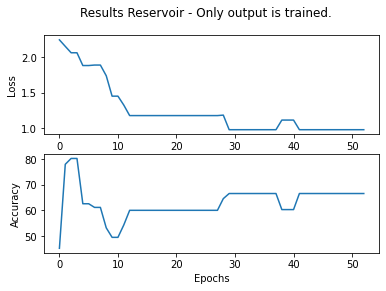

In [123]:
plot_results(best_unit['epoch'], best_unit['loss_results'], best_unit['accuracy_results'])